Данный ноутбук содержит пример обучения VAE.
Код заимствован с [этого](https://github.com/eugeniaring/Pytorch-tutorial/blob/main/VAE_mnist.ipynb) GitHub

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import random 
import os
from tqdm.auto import tqdm
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px

In [ ]:
data_dir = 'dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)



In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [ ]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [ ]:
train_data

## 1.Define Encoder and Decoder classes

Также стоит держать в голове формулы для рассчета размера выхода после \
**Convolutional и Max/Avg pooling слоев:**
$$\dfrac{W−F+2P}{S}+1$$

- W is the input height/width (normally the images are squares, so there is no need to differentiate the two)
- F is the filter/kernel size
- P is the padding
- S is the stride

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        # out_width = (28+2-5)/2+1 = 27/2+1 = 13
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # out_width = (14-5)/2+1 = 5
        #self.drop1=nn.Dropout2d(p=0.3) 
        # 6 * 6 * 16 = 576
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        #print(x.shape)
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))

        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

Объяснение почему `self.kl` выглядит таким образом приведено на [Stack Exchange](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians)

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## 2.Initialize model, optimizer, loss

In [ ]:
torch.manual_seed(0)  # Set the random seed for reproducible results

d = 4  # number of latent dimensions

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

## 3.Training

In [ ]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [ ]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [ ]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

  0%|          | 0/50 [00:00<?, ?it/s]


 EPOCH 1/50 	 train loss 141.752 	 val loss 76.815


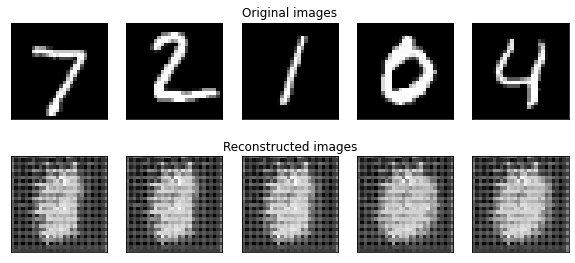


 EPOCH 2/50 	 train loss 61.791 	 val loss 51.099


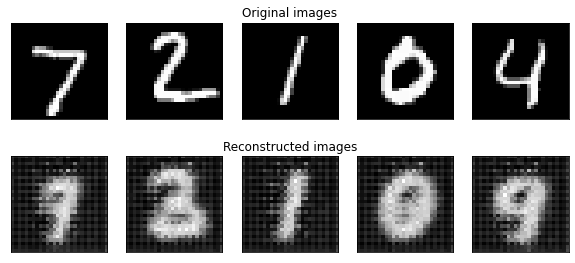


 EPOCH 3/50 	 train loss 46.674 	 val loss 42.271


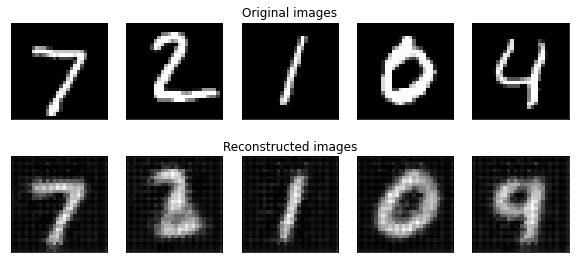


 EPOCH 4/50 	 train loss 40.140 	 val loss 38.584


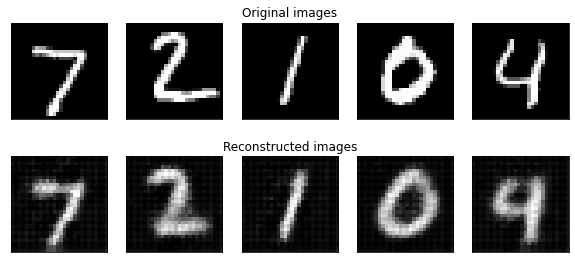


 EPOCH 5/50 	 train loss 37.637 	 val loss 36.762


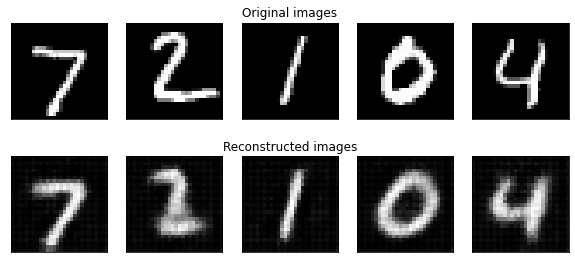


 EPOCH 6/50 	 train loss 36.388 	 val loss 36.029


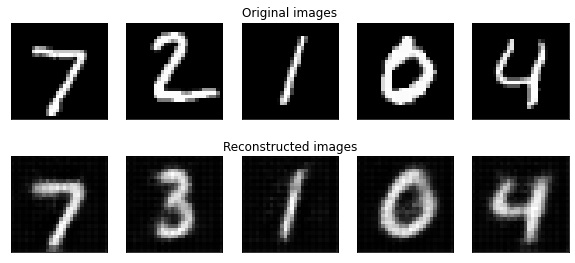


 EPOCH 7/50 	 train loss 35.652 	 val loss 35.349


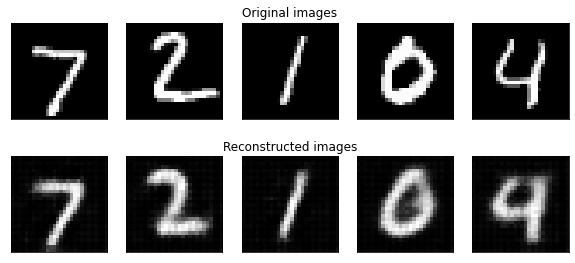


 EPOCH 8/50 	 train loss 35.120 	 val loss 35.006


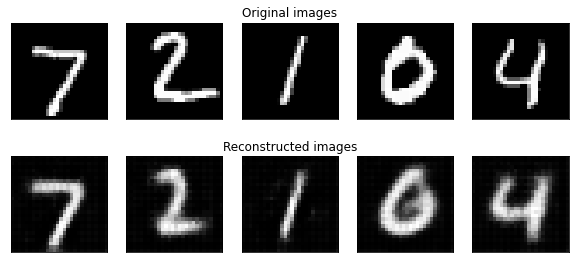


 EPOCH 9/50 	 train loss 34.746 	 val loss 34.687


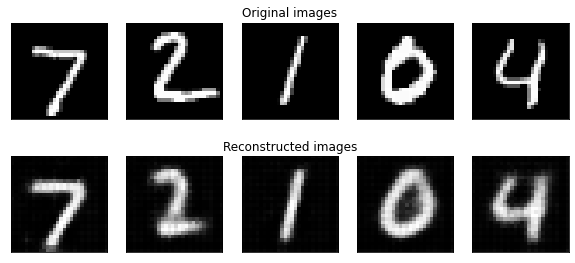


 EPOCH 10/50 	 train loss 34.402 	 val loss 34.301


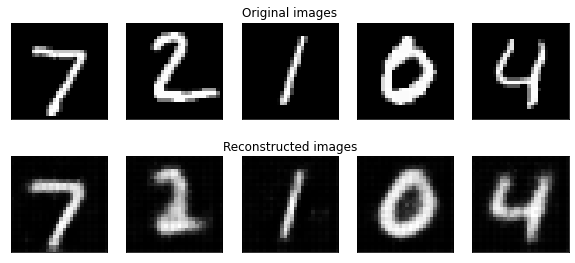


 EPOCH 11/50 	 train loss 34.189 	 val loss 34.205


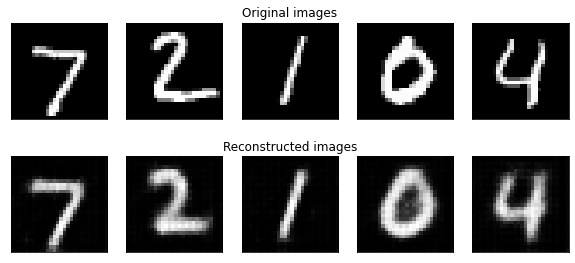


 EPOCH 12/50 	 train loss 33.969 	 val loss 33.934


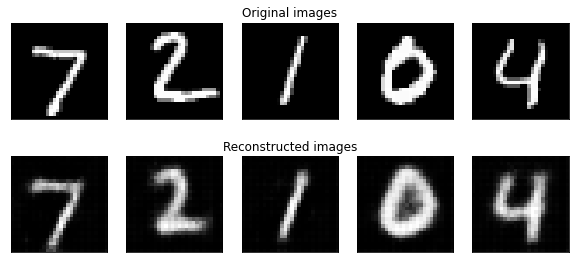


 EPOCH 13/50 	 train loss 33.799 	 val loss 33.981


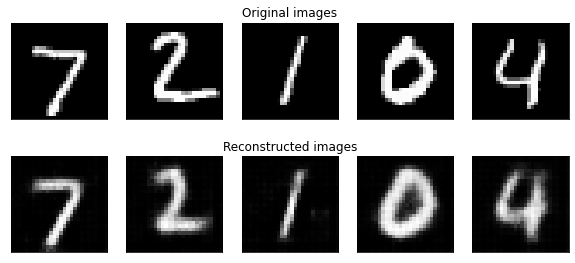


 EPOCH 14/50 	 train loss 33.641 	 val loss 33.758


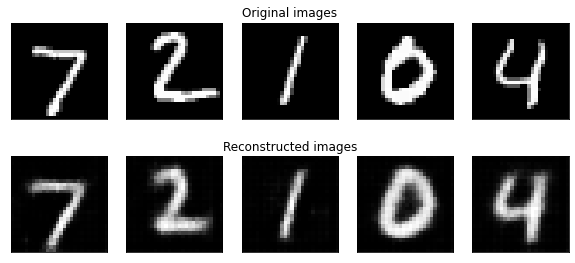


 EPOCH 15/50 	 train loss 33.486 	 val loss 33.630


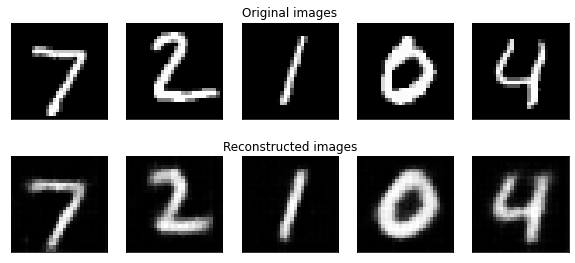


 EPOCH 16/50 	 train loss 33.382 	 val loss 33.533


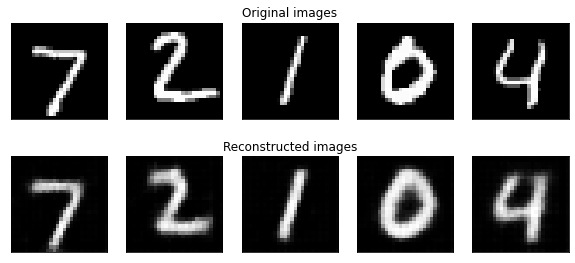


 EPOCH 17/50 	 train loss 33.286 	 val loss 33.510


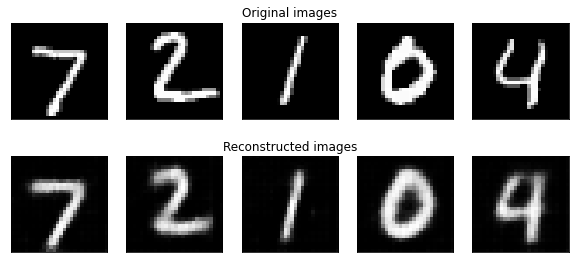


 EPOCH 18/50 	 train loss 33.189 	 val loss 33.434


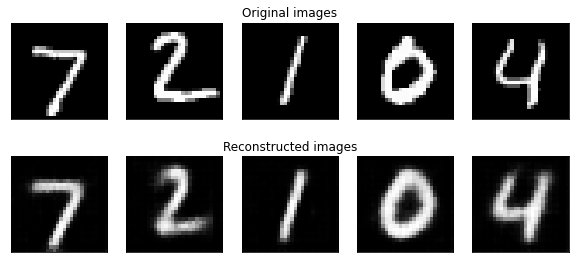


 EPOCH 19/50 	 train loss 33.126 	 val loss 33.342


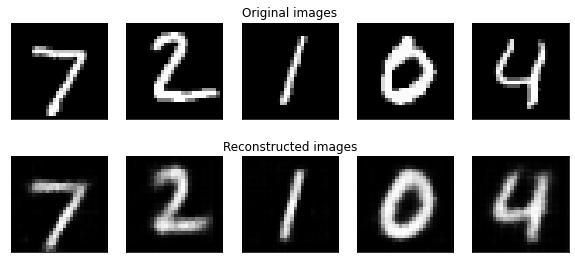


 EPOCH 20/50 	 train loss 33.017 	 val loss 33.218


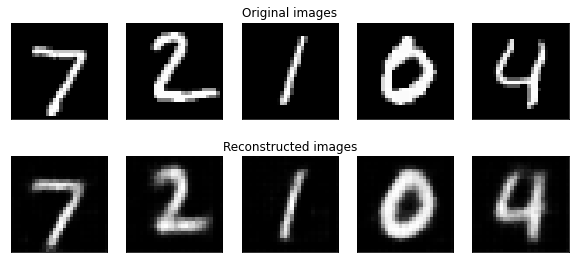


 EPOCH 21/50 	 train loss 32.932 	 val loss 33.109


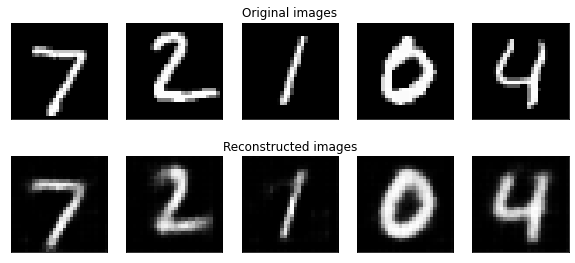


 EPOCH 22/50 	 train loss 32.854 	 val loss 33.137


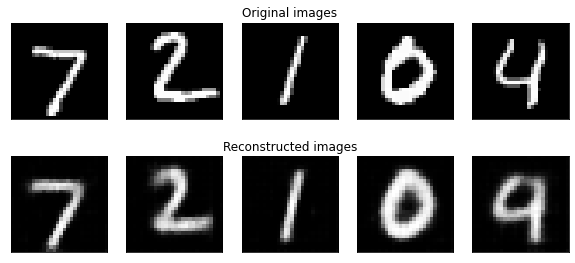


 EPOCH 23/50 	 train loss 32.791 	 val loss 33.047


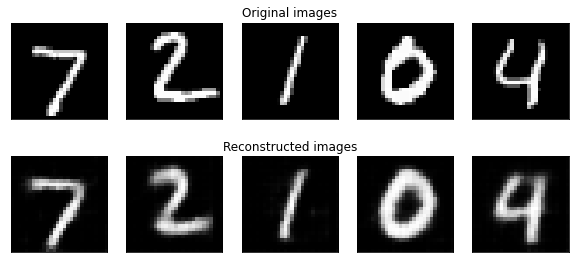


 EPOCH 24/50 	 train loss 32.699 	 val loss 32.909


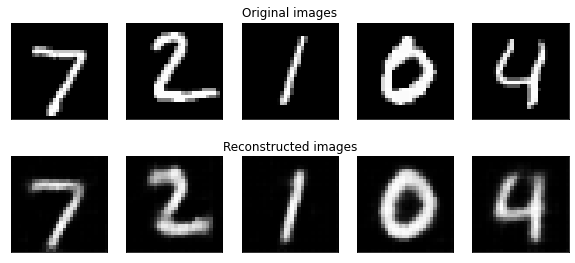


 EPOCH 25/50 	 train loss 32.655 	 val loss 32.916


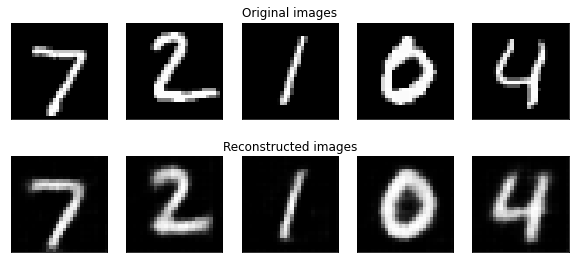


 EPOCH 26/50 	 train loss 32.597 	 val loss 32.996


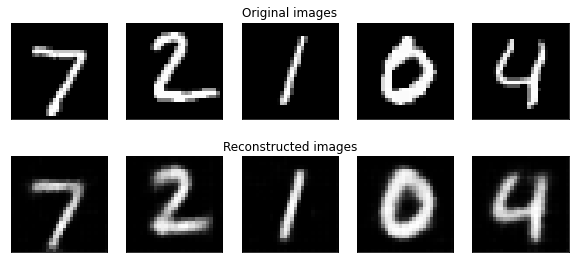


 EPOCH 27/50 	 train loss 32.554 	 val loss 32.766


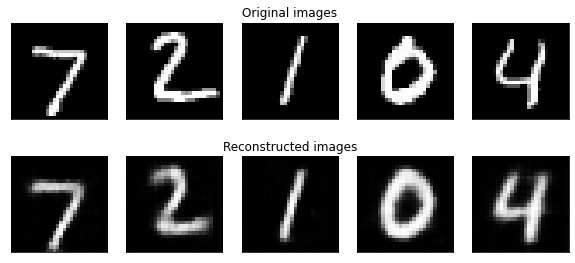


 EPOCH 28/50 	 train loss 32.505 	 val loss 32.737


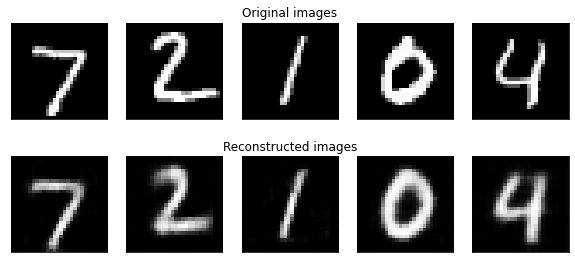


 EPOCH 29/50 	 train loss 32.439 	 val loss 32.660


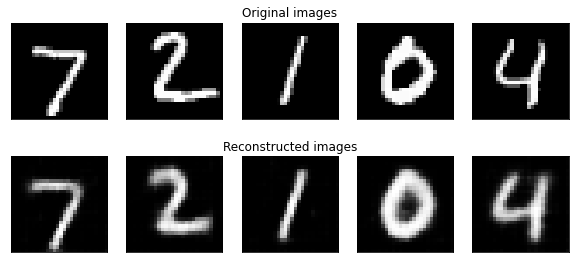


 EPOCH 30/50 	 train loss 32.409 	 val loss 32.720


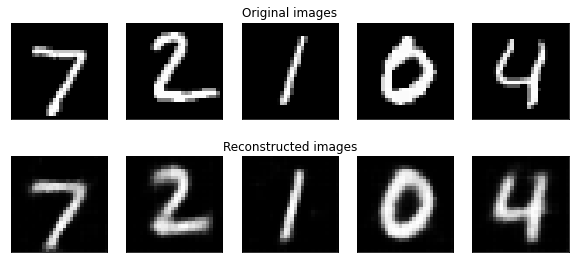


 EPOCH 31/50 	 train loss 32.365 	 val loss 32.601


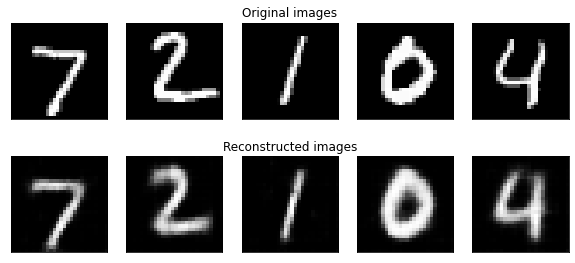


 EPOCH 32/50 	 train loss 32.308 	 val loss 32.635


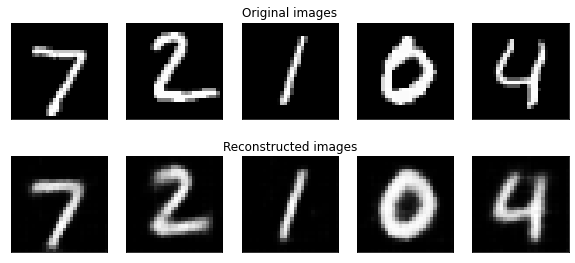


 EPOCH 33/50 	 train loss 32.239 	 val loss 32.510


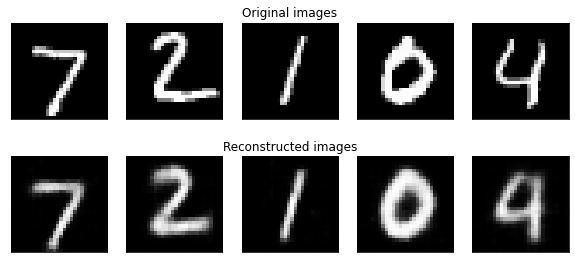


 EPOCH 34/50 	 train loss 32.236 	 val loss 32.450


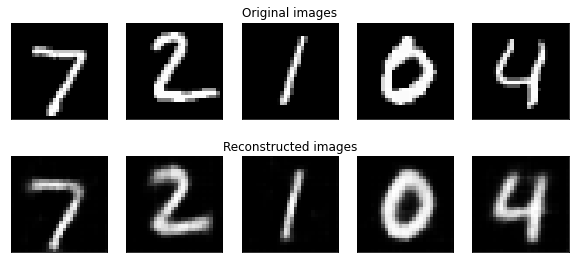


 EPOCH 35/50 	 train loss 32.200 	 val loss 32.556


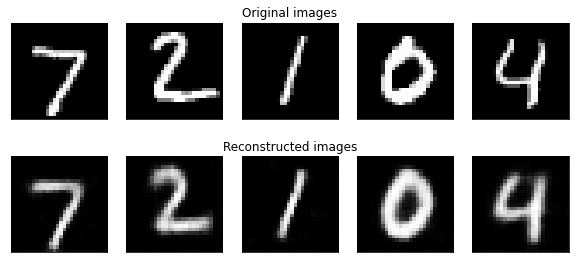


 EPOCH 36/50 	 train loss 32.174 	 val loss 32.506


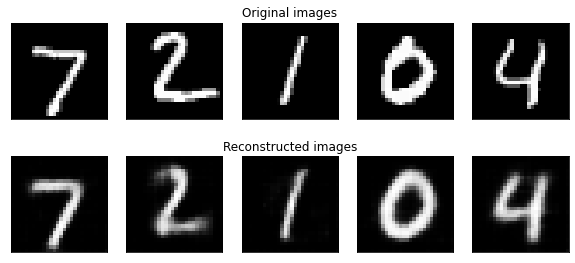


 EPOCH 37/50 	 train loss 32.124 	 val loss 32.445


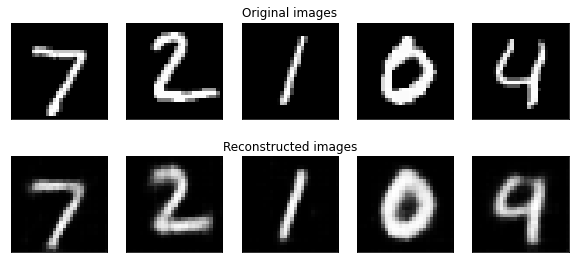


 EPOCH 38/50 	 train loss 32.074 	 val loss 32.446


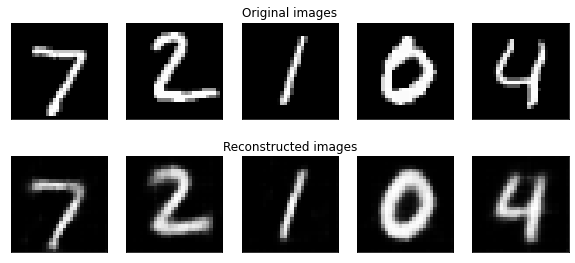


 EPOCH 39/50 	 train loss 32.058 	 val loss 32.412


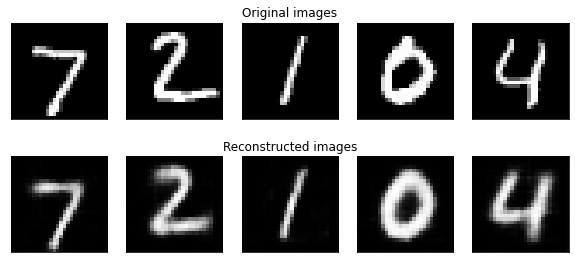


 EPOCH 40/50 	 train loss 32.036 	 val loss 32.328


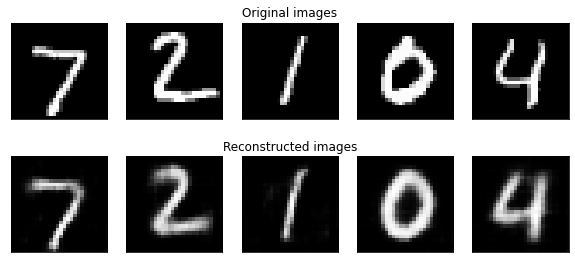


 EPOCH 41/50 	 train loss 32.010 	 val loss 32.289


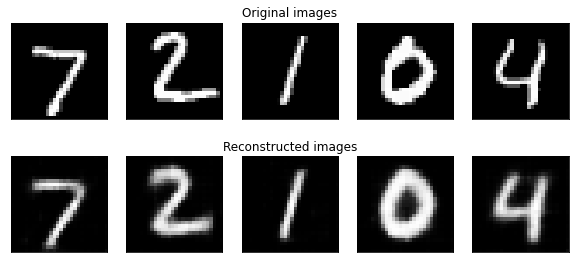


 EPOCH 42/50 	 train loss 31.952 	 val loss 32.351


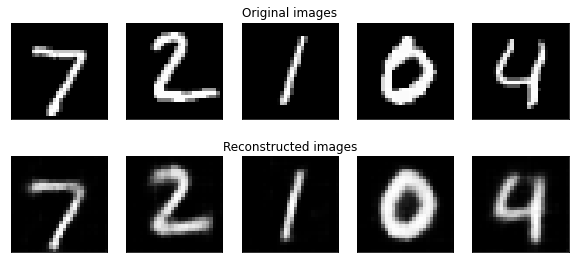


 EPOCH 43/50 	 train loss 31.970 	 val loss 32.374


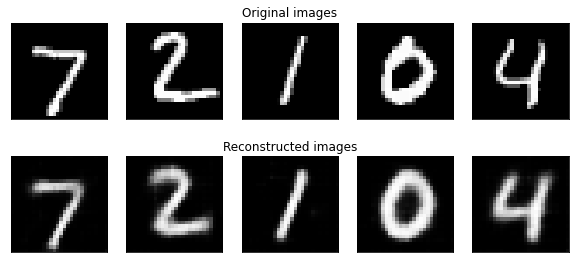


 EPOCH 44/50 	 train loss 31.920 	 val loss 32.456


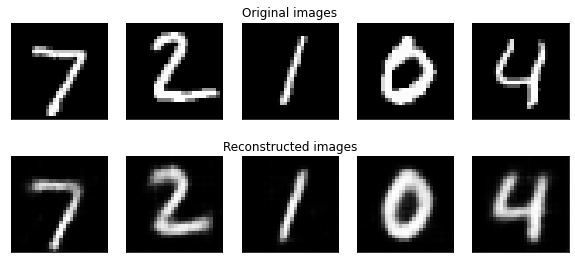


 EPOCH 45/50 	 train loss 31.906 	 val loss 32.267


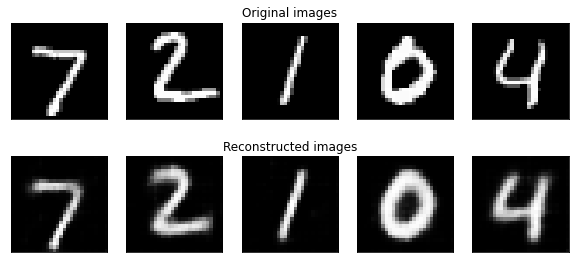


 EPOCH 46/50 	 train loss 31.868 	 val loss 32.205


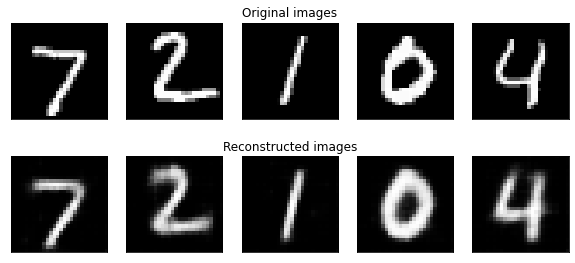


 EPOCH 47/50 	 train loss 31.836 	 val loss 32.178


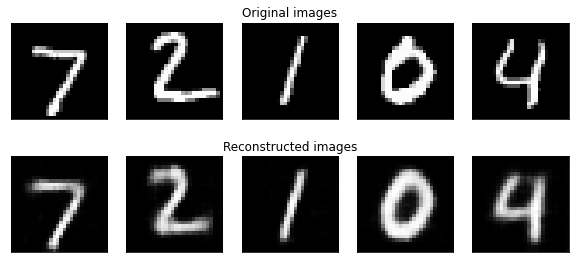


 EPOCH 48/50 	 train loss 31.805 	 val loss 32.152


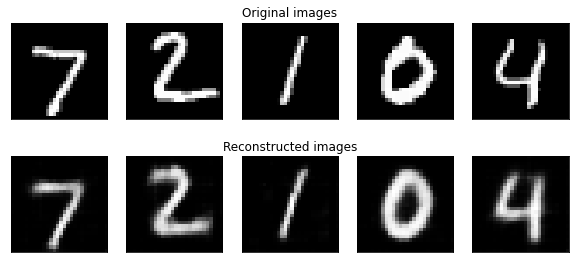


 EPOCH 49/50 	 train loss 31.801 	 val loss 32.236


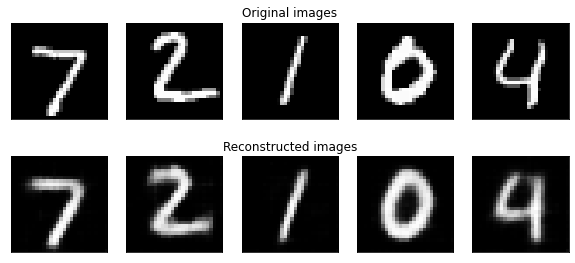


 EPOCH 50/50 	 train loss 31.766 	 val loss 32.192


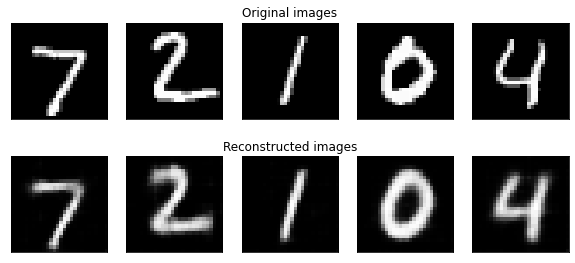

In [ ]:
num_epochs = 50
for epoch in tqdm(range(num_epochs)):

   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

   plot_ae_outputs(vae.encoder,vae.decoder,n=5)

## 4.Generate samples

In [ ]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

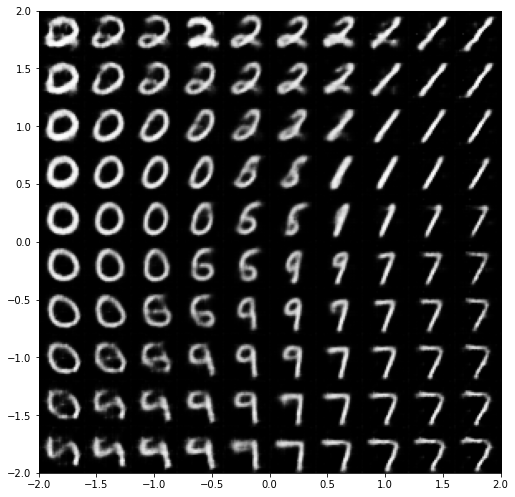

In [ ]:
plot_reconstructed(vae.decoder, r0=(-2, 2), r1=(-2, 2))

## 5.Visualize latent space

In [ ]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,1.176252,-0.958337,-0.298464,-0.321517,7
1,0.874526,0.826758,0.240268,1.487970,2
2,1.470482,-0.047182,1.324720,0.551330,1
3,-1.011528,0.446788,0.551919,0.051982,0
4,-0.349220,-0.764461,0.515483,-0.892148,4
...,...,...,...,...,...
9995,-0.185568,1.166477,-0.456382,1.379585,2
9996,-0.882335,0.253772,-0.063756,1.528197,3
9997,0.508334,-0.139078,0.864899,-0.688346,4
9998,0.000229,0.707433,-0.131470,-1.229592,5


In [ ]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

In [ ]:
fig = px.scatter(tsne_results, x=0, y=1, 
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()